In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [24]:
# Here I have loaded the Titanic dataset and prepared the features (X) and target (y).
data = pd.read_csv('train.csv')
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)  # Drop non-numeric or irrelevant columns
y = data['Survived']  # Target variable: Survived (1) or Not Survived (0)

In [25]:
# Here I have encoded the categorical variables ('Sex' and 'Embarked') into numeric values using LabelEncoder.
# This step ensures that XGBoost can process the data without errors.
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Handle missing values by converting to string
    label_encoders[col] = le  # Save the encoder for later use if needed

In [26]:
# Here I have split the dataset into training and validation sets for model evaluation.
# The training set is used to train the model, while the validation set is used to evaluate its performance.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Here I have converted the training and validation datasets into DMatrix format, which is optimized for XGBoost.
# DMatrix is a specialized data structure that improves the efficiency of XGBoost's computations.
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [28]:
# Here I have defined the hyperparameters for the XGBoost model.
# These parameters control the behavior of the model, such as the objective function, evaluation metric, and learning rate.
params = {
    'objective': 'binary:logistic',  # Binary classification problem
    'eval_metric': 'logloss',        # Logarithmic loss for binary classification
    'max_depth': 6,                  # Maximum depth of each tree
    'eta': 0.1                       # Learning rate (step size shrinkage)
}

In [29]:
# Initialize lists to store evaluation results
train_loss = []
val_loss = []

In [32]:
# Define a custom callback to track evaluation metrics
class EvalCallback(xgb.callback.TrainingCallback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []

    def after_iteration(self, model, epoch, evals_log):
        # Store training and validation log loss
        self.train_loss.append(evals_log['train']['logloss'][-1])
        self.val_loss.append(evals_log['validation']['logloss'][-1])
        return False  # Return False to continue training

In [33]:
# Create an instance of the custom callback
eval_callback = EvalCallback()

In [34]:
# Here I have trained the XGBoost model using the training data.
# The model is evaluated on the validation set during training to monitor its performance.
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,             # Maximum number of boosting rounds
    evals=[(dtrain, 'train'), (dval, 'validation')],  # Evaluate on both training and validation sets
    early_stopping_rounds=10,        # Stop training if no improvement after 10 rounds
    verbose_eval=False,              # Suppress verbose output during training
    callbacks=[eval_callback]        # Use the custom callback to track metrics
)

In [35]:
# Extract the tracked metrics from the callback
train_loss = eval_callback.train_loss
val_loss = eval_callback.val_loss

In [36]:
# Here I have made predictions on the validation set using the trained XGBoost model.
# The `predict` method outputs probabilities for the positive class, which are then converted to binary predictions.
y_pred_prob = bst.predict(dval)     # Predict probabilities for the positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (threshold = 0.5)

In [37]:
# Here I have calculated various evaluation metrics to assess the model's performance.
print("Accuracy:", accuracy_score(y_val, y_pred))  # Proportion of correct predictions
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))  # Breakdown of true vs. predicted classes
print("Classification Report:\n", classification_report(y_val, y_pred))  # Precision, recall, F1-score, etc.
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_prob))  # Area under the ROC curve

Accuracy: 0.8212290502793296
Confusion Matrix:
 [[95 10]
 [22 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

ROC AUC Score: 0.8839124839124839


<Figure size 1000x600 with 0 Axes>

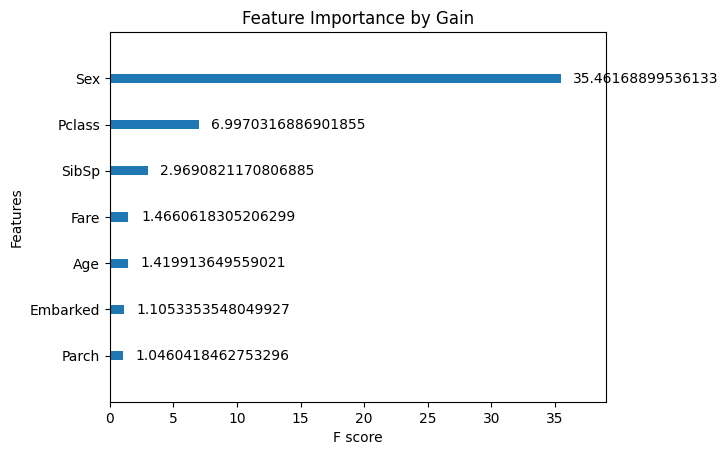

In [38]:
# Here I have plotted the feature importance graph to visualize which features contribute most to the model's predictions.
# The `gain` metric measures the contribution of each feature to the splits in the trees.
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type='gain', grid=False)
plt.title("Feature Importance by Gain")
plt.show()

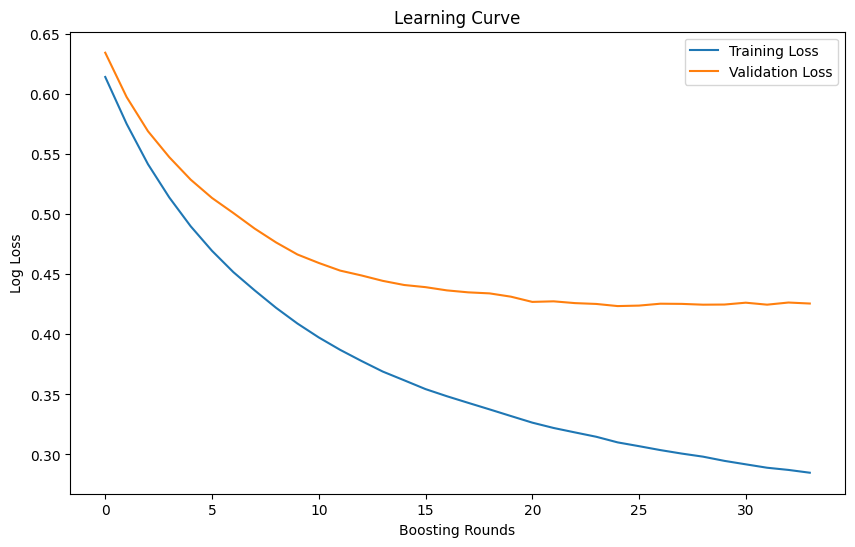

In [39]:
# Here I have created a learning curve to visualize how the training and validation loss change over boosting rounds.
# This helps diagnose issues like overfitting or underfitting.
epochs = range(len(val_loss))  # Number of boosting rounds
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')  # Plot training loss
plt.plot(epochs, val_loss, label='Validation Loss')  # Plot validation loss
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

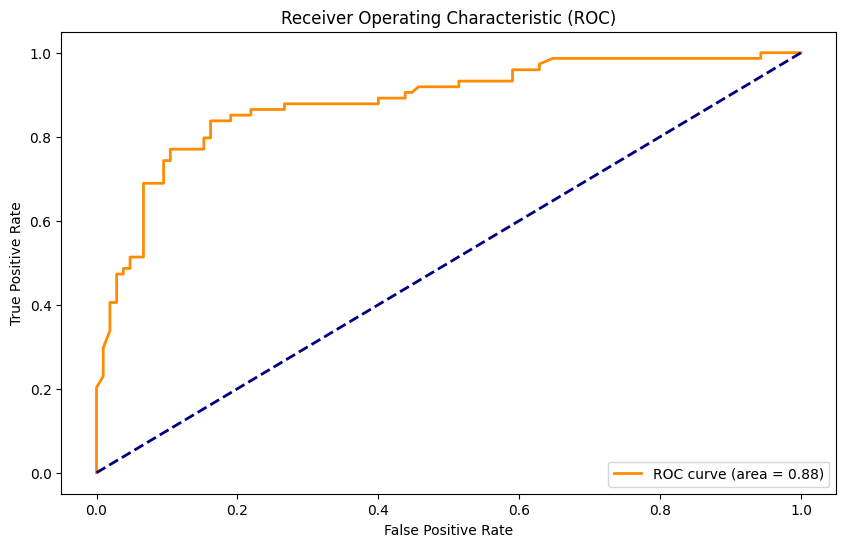

In [40]:
# Here I have plotted the ROC curve to evaluate the model's ability to distinguish between the two classes.
# The ROC curve shows the trade-off between the True Positive Rate (TPR) and False Positive Rate (FPR).
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)  # Calculate FPR and TPR
roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

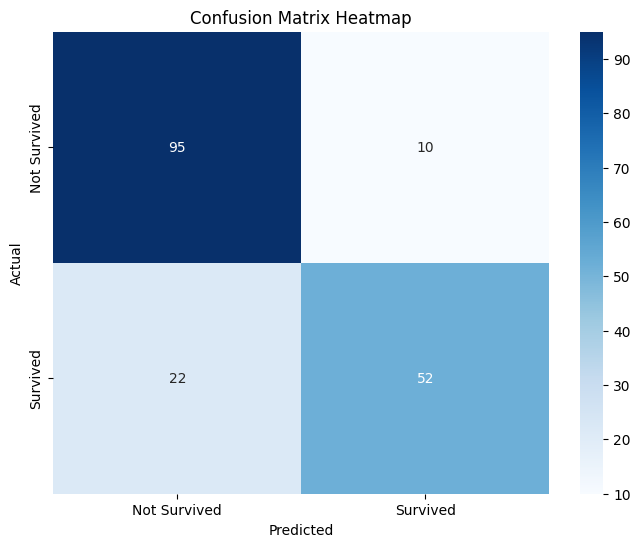

In [41]:
# Here I have visualized the confusion matrix as a heatmap to better understand the classification results.
# The confusion matrix shows the counts of true positives, false positives, true negatives, and false negatives.
cm = confusion_matrix(y_val, y_pred)  # Confusion matrix values
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])  # Heatmap with labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()